In [141]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline
#handling warnings
import warnings
warnings.filterwarnings('ignore')
warnings.MarkupResemblesLocatorWarnings = False

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
#nltk.download('stopwords')

In [142]:
train_csv = "rt_reviews.csv"
df = pd.read_csv(train_csv, encoding='ISO-8859-1')

In [143]:
df.head()

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


In [144]:
Freshness_mapping = {'fresh': 1, 'rotten': 0}
df = df.applymap(lambda s: Freshness_mapping.get(s) if s in Freshness_mapping else s)
df.head()

,Freshness,Review
0,1,"Manakamana doesn't answer any questions, yet ..."
1,1,Wilfully offensive and powered by a chest-thu...
2,0,It would be difficult to imagine material mor...
3,0,Despite the gusto its star brings to the role...
4,0,If there was a good idea at the core of this ...


In [ ]:
dict_types = df['Freshness'].unique()
def calculate_prior_probability(): 
  sentence_type_prior_probability = dict()
  total_sentence_type_count = df['Freshness'].size
  for key_type, value_count in dict_types.items():
    sentence_type_prior_probability[key_type] = value_count / total_sentence_type_count;
  return sentence_type_prior_probability

for key_type, probability in calculate_prior_probability().items():
  print(key_type + ": " + str(probability))

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_sentence = set(stopwords.words('english'))
# print(stop_words_sentence)
# Remove Stop words


def build_vacabulary(sentences, remove_stop_words = False):
  # print(sentences)
  vocabulary_list = []
  dictionary_word_count = {}
  for sentence in sentences:
    words_in_sentence = str(sentence).split(' ')
    for each_word in words_in_sentence:
      # remove white spaces
      each_word = re.sub(r'\d', ' ', each_word)
      each_word = str(each_word).strip()
      if each_word == "":
          continue
      if remove_stop_words:
        if each_word in stop_words_sentence:
          continue  
      if each_word in dictionary_word_count.keys():
        dictionary_word_count[each_word] += 1
      else:
        dictionary_word_count[each_word] = 1
        vocabulary_list.append(each_word)
  # Now omitting rare words, whose count is < 5 - 
  dictionary_word_count = {key: val for key,
            val in dictionary_word_count.items() if val > 5}
  return dictionary_word_count, vocabulary_list

dictionary_word_count, vocabulary_list = build_vacabulary(ford_dataset_train_X)
print(vocabulary_list)
print(dictionary_word_count)

In [ ]:
def calculate_probability_each_word(data, remove_stop_words = False):
  dictionary_word_count, vocabulary_list = build_vacabulary(data, remove_stop_words)
  total_count_words = sum(dictionary_word_count.values())
  probability_each_word = {}
  for each_word, count in dictionary_word_count.items():
    probability_each_word[each_word] = count / total_count_words
  return probability_each_word

probability_each_word = calculate_probability_each_word(x_train, True)
print(probability_each_word)

In [ ]:
def calculate_conditional_probability(class_type, data, stop_words_remove = False):
  conditional_probability = dict()
  text = data.loc[data.Freshness == class_type].Review
  sentences_length = len(text)
  # print(sentences_length)
  dictionary_word_count = {}
  vocabulary_list = []
  dictionary_word_count, vocabulary_list = build_vacabulary(text, stop_words_remove)


  for each_word, count in dictionary_word_count.items():
    conditional_probability[each_word] = count / sum(dictionary_word_count.values())
  return conditional_probability

In [ ]:
import operator
for type in dict_types:  
  conditional_probability = calculate_conditional_probability(type, x_train, False)
  print("Sentence Type : " + type.upper())
  sorted_probability = dict(sorted(conditional_probability.items(), key = lambda x: x[1], reverse = True))
  print(sorted_probability)
  # Let's find top 10 words that predicts each class before removing stop words
  sorted_probability = dict(sorted(conditional_probability.items(), key=operator.itemgetter(1), reverse=True)[:10])
  print("Top 10 words: ")
  print(sorted_probability)
  print()

In [145]:
print(df.columns)
print(df.shape)

train_size = int(len(df) * 0.8)
test_size = int(len(df) * 0.1)
val_size = int(len(df) * 0.1)

train_df = df[:train_size]
test_df = df[train_size:train_size + test_size]
val_df = df[train_size + test_size:train_size + test_size + val_size]

print("train_df : ", train_df.shape)
print("test_df : ", test_df.shape)
print("val_df : ", val_df.shape)


Index(['Freshness', 'Review'], dtype='object')
(480000, 2)
train_df :  (384000, 2)
test_df :  (48000, 2)
val_df :  (48000, 2)


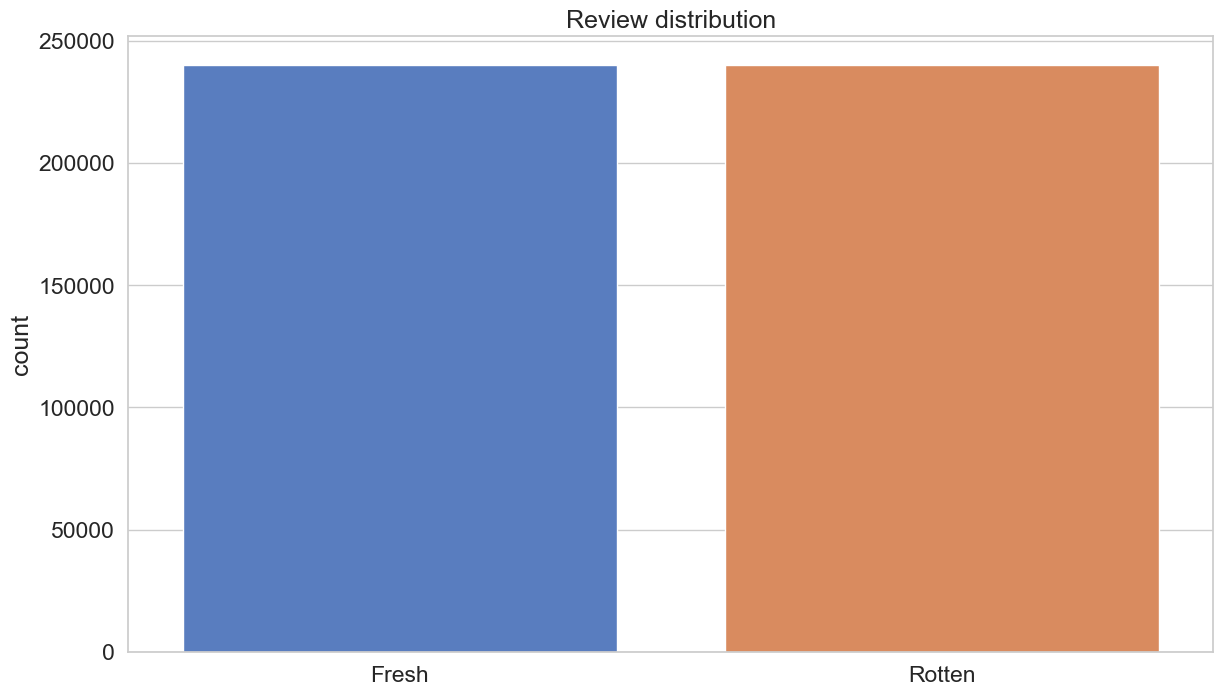

In [146]:
f = sns.countplot(x='Freshness', data=df)
f.set_title("Review distribution")
f.set_xticklabels(['Fresh', 'Rotten'])
plt.xlabel("");

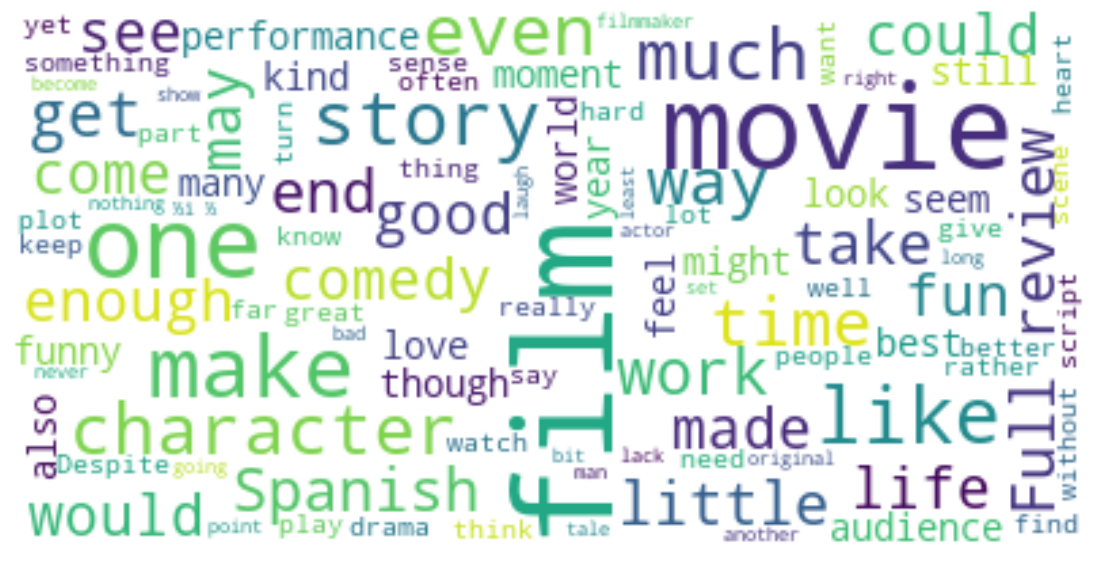

In [147]:
text = " ".join(Review for Review in df.Review)


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [148]:
class Tokenizer:
  
  def clean(self, text):
      no_html = BeautifulSoup(text).get_text()
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      clean = self.clean(text).lower()
      stopwords_en = stopwords.words("english")
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]

In [149]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class, alpha):
      num = self.word_counts[text_class][word] + alpha
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X, alpha = 1.0):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c, alpha)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result


In [150]:
X_train = train_df['Review'].values
y_train = train_df['Freshness'].values

X_test = test_df['Review'].values
y_test = test_df['Freshness'].values

X_val = val_df['Review'].values
y_val = val_df['Freshness'].values

In [151]:
model = MultinomialNaiveBayes(classes=np.unique(y_train), tokenizer=Tokenizer()).fit(X_train, y_train)

In [152]:
target_names = ['fresh', 'rotten']
y_pred05 = model.predict(X_test, alpha=0.5)
acc_scr_05=accuracy_score(y_test, y_pred05)
print(acc_scr_05)
print(classification_report(y_test, y_pred05, target_names=target_names))

0.7990833333333334
              precision    recall  f1-score   support

       fresh       0.82      0.77      0.79     24141
      rotten       0.78      0.83      0.80     23859

    accuracy                           0.80     48000
   macro avg       0.80      0.80      0.80     48000
weighted avg       0.80      0.80      0.80     48000



In [153]:
y_pred1 = model.predict(X_test, alpha=1.0)
acc_scr_1=accuracy_score(y_test, y_pred1)
print(acc_scr_1)
print(classification_report(y_test, y_pred1))

0.7981458333333333
              precision    recall  f1-score   support

           0       0.82      0.77      0.79     24141
           1       0.78      0.83      0.80     23859

    accuracy                           0.80     48000
   macro avg       0.80      0.80      0.80     48000
weighted avg       0.80      0.80      0.80     48000



In [154]:
y_pred01 = model.predict(X_test, alpha=0.1)
acc_scr_01=accuracy_score(y_test, y_pred01)
print(acc_scr_01)
print(classification_report(y_test, y_pred01))

0.7985208333333333
              precision    recall  f1-score   support

           0       0.82      0.77      0.79     24141
           1       0.78      0.82      0.80     23859

    accuracy                           0.80     48000
   macro avg       0.80      0.80      0.80     48000
weighted avg       0.80      0.80      0.80     48000



In [155]:
y_pred001 = model.predict(X_test, alpha=0.01)
acc_scr_001=accuracy_score(y_test, y_pred001)
print(acc_scr_001)
print(classification_report(y_test, y_pred001))

0.7962083333333333
              precision    recall  f1-score   support

           0       0.81      0.77      0.79     24141
           1       0.78      0.82      0.80     23859

    accuracy                           0.80     48000
   macro avg       0.80      0.80      0.80     48000
weighted avg       0.80      0.80      0.80     48000



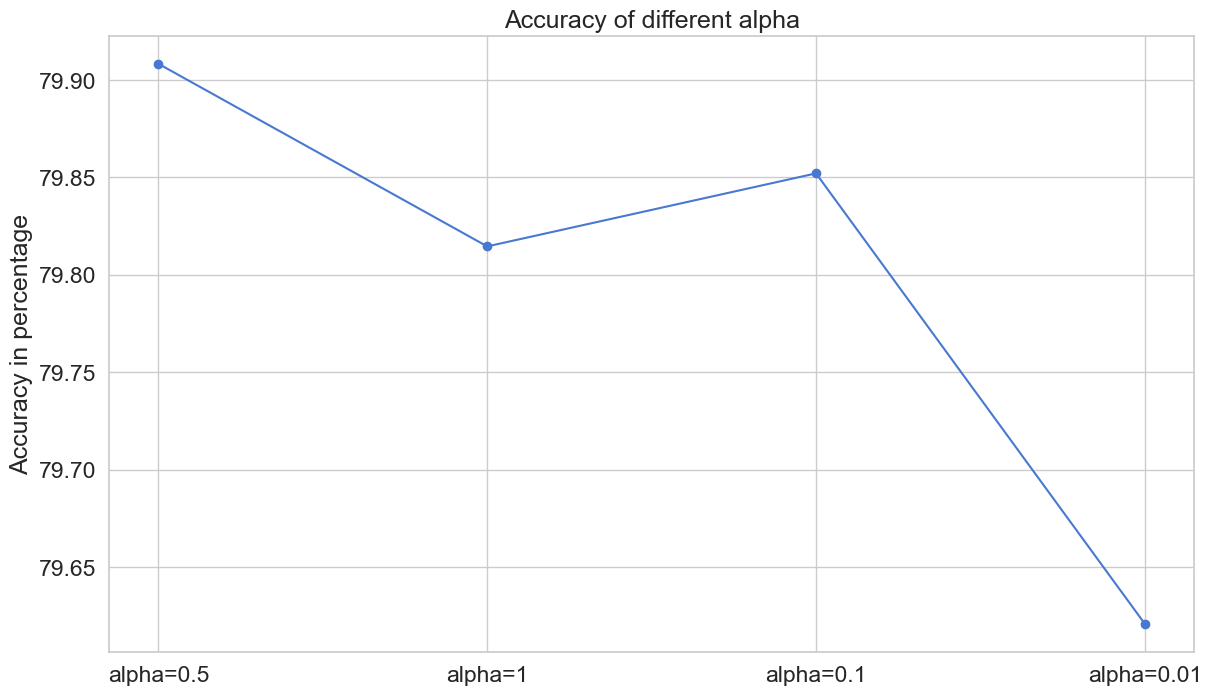

In [156]:
#compare accuracy of different alpha in bar graph
objects = ('alpha=0.5', 'alpha=1', 'alpha=0.1', 'alpha=0.01')
y_pos = np.arange(len(objects))
performance = [acc_scr_05*100, acc_scr_1*100, acc_scr_01*100, acc_scr_001*100]
#plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.plot(y_pos, performance, marker='o')

plt.xticks(y_pos, objects)
plt.ylabel('Accuracy in percentage')
plt.title('Accuracy of different alpha')
plt.show()

In [157]:
#print(classification_report(y_test, y_pred))

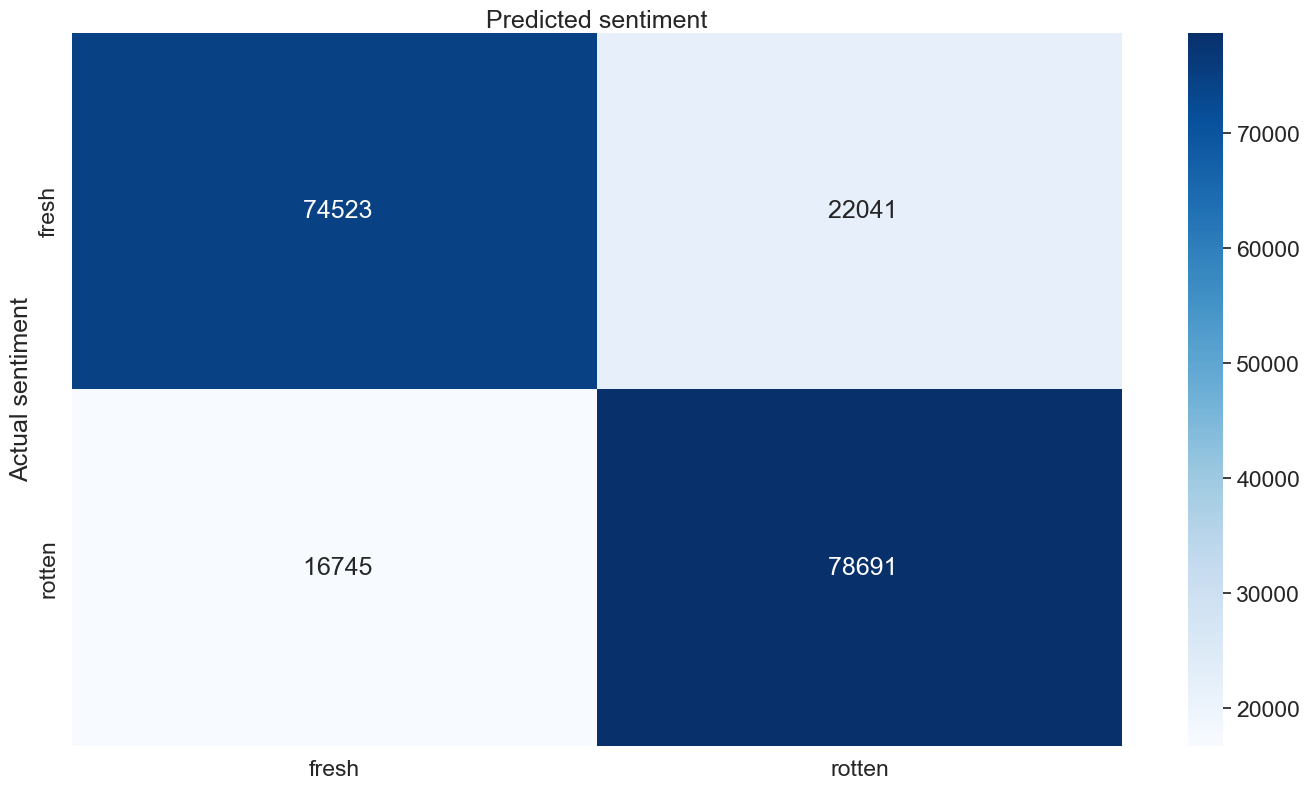

In [158]:
cnf_matrix05 = confusion_matrix(y_test, y_pred05)
cnf_matrix1 = confusion_matrix(y_test, y_pred1)
cnf_matrix01 = confusion_matrix(y_test, y_pred01)
cnf_matrix001 = confusion_matrix(y_test, y_pred001)

merged_matrix = np.add(np.add(np.add(cnf_matrix05, cnf_matrix1), cnf_matrix01), cnf_matrix001)

class_names = ["fresh", "rotten"]
fig,ax = plt.subplots()

sns.heatmap(pd.DataFrame(merged_matrix), annot=True, cmap="Blues", fmt="6", xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');